## Berry vs Grape Image Classification

*This notebook is largely based on [this tutorial](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson2-download.ipynb) from [fast.ai](https://www.fast.ai/)*

What it aims to do is classify a picture of berries as blue, black or grapes. This is just so I can see how good it can become at differentiating between similar looking images. 

In [1]:
from fastai.vision import *

**Get images from google**

1. Search Google Images & load all the images you want
2. Enter the following code after pressing `cmd-Opt-j`
>`urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));` <br> `window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));`

**Create directories for images**

In [2]:
folder = 'blue'
file = 'blueberries.csv'

In [3]:
path = Path('data/berries')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [4]:
folder = 'grape'
file = 'grapes.csv'

In [5]:
path = Path('data/berries')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [6]:
folder = 'black'
file = 'blackberries.csv'

In [7]:
path = Path('data/berries')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [8]:
path.ls()

[PosixPath('data/berries/black'),
 PosixPath('data/berries/grape'),
 PosixPath('data/berries/blue')]

In [9]:
classes = ['blue','grape','black']

*Next, place the* **csv files** *into the* **directory**

**Downloading the Images**

*Note: If it doesn't work the first time, add max_workers = 0 to debug*

In [10]:

path = Path('data/berries')
folder = 'blue'
file = 'blueberries.csv'
dest = path/folder
download_images(path/file, dest, max_pics=200)

path = Path('data/berries')
folder = 'grape'
file = 'grapes.csv'
dest = path/folder
download_images(path/file, dest, max_pics=200)

path = Path('data/berries')
folder = 'black'
file = 'blackberries.csv'
dest = path/folder
download_images(path/file, dest, max_pics=200)

**Cleaning up the images**

In [11]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

blue


grape


black


**Loading the images as data**

In [12]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=2).normalize(imagenet_stats)

In [13]:
data.classes

['black', 'blue', 'grape']

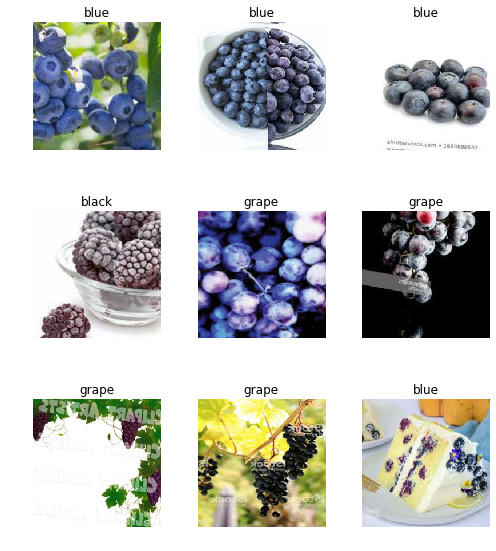

In [14]:
data.show_batch(rows=3, figsize=(7,8))


In [15]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)


(['black', 'blue', 'grape'], 3, 480, 120)

**Train Model**

In [16]:
model = cnn_learner(data, models.resnet34, metrics=error_rate)

In [17]:
model.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.577304,1.205097,0.375000,00:06
1,1.053187,0.694695,0.208333,00:04
2,0.793971,0.686841,0.183333,00:04
3,0.643583,0.658043,0.191667,00:04


In [19]:
model.save('model-1')


*The model appears to have a learning rate that is too low as the validation loss is greater than the training loss at points, indicating that we aren't fitting the data enough*

In [20]:
model.unfreeze()

In [21]:
model.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


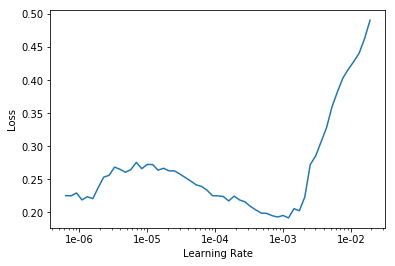

In [23]:
model.recorder.plot()

In [24]:
model.fit_one_cycle(3, max_lr=slice(5e-5,1e-4))


epoch,train_loss,valid_loss,error_rate,time
0,0.255047,0.645228,0.158333,00:05
1,0.212066,0.602439,0.166667,00:05
2,0.164279,0.601028,0.166667,00:05


In [25]:
model.save('model-2')

Our model with the lowest error_rate appears to be model 2. <br>
**Let's load this model and see what the results indicate.**

In [26]:
model.load('model-2');

In [27]:
interp = ClassificationInterpretation.from_learner(model)

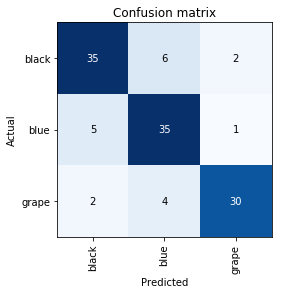

In [28]:
interp.plot_confusion_matrix()

*It appears that our model has a tough time with some blue and black berries.*
*Let's visualize some of these errors*

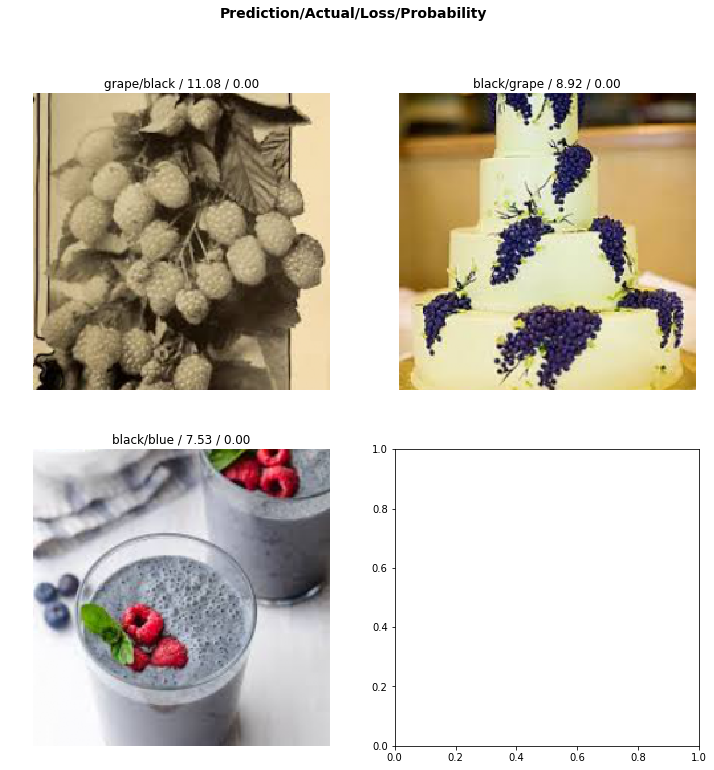

In [29]:
interp.plot_top_losses(k=3)

*As we can see, some of these make sense as they are really noisy photos... let's clean up the photos and then, see how our model performs*

### Cleaning Up

In [30]:
from fastai.widgets import *

In [31]:
#not quite sure what this is doing
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [32]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)
learn_cln.load('model-2');

In [33]:
#not sure what this does
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [35]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

*Now that we have cleaned our dataset, we must recreate our model from the cleaned.csv file*

In [36]:
path = Path('data/berries')
np.random.seed(42)
cleaned_data = ImageDataBunch.from_csv(path, size=224, valid_pct=0.2,
    ds_tfms=get_transforms(), csv_labels='cleaned.csv').normalize(imagenet_stats)

In [37]:
cleaned_data.classes

['black', 'blue', 'grape']

In [38]:
cleaned_data.classes, cleaned_data.c, len(cleaned_data.train_ds), len(cleaned_data.valid_ds)


(['black', 'blue', 'grape'], 3, 466, 116)

In [39]:
clean_model = cnn_learner(cleaned_data, models.resnet34, metrics=error_rate)

In [40]:
clean_model.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.386402,0.772207,0.293103,00:05
1,0.963616,0.325445,0.094828,00:05
2,0.713280,0.268121,0.086207,00:04
3,0.592865,0.271233,0.068966,00:05


In [41]:
clean_model.save('model-1')

In [42]:
clean_model.load('model-1');

In [43]:
clean_model.unfreeze()

In [44]:
clean_model.lr_find(start_lr=1e-5, end_lr=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


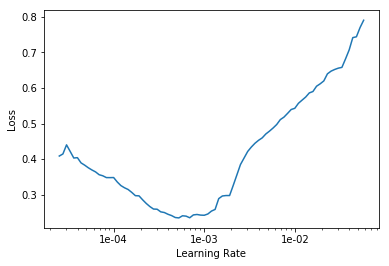

In [60]:
clean_model.recorder.plot()

In [45]:
clean_model.fit_one_cycle(3, max_lr=slice(5e-5,1e-4))


epoch,train_loss,valid_loss,error_rate,time
0,0.245183,0.227542,0.060345,00:06
1,0.219885,0.253150,0.060345,00:06
2,0.200832,0.251317,0.060345,00:06


In [46]:
clean_model.save('model-2')

*So it appears our best error_rate is 0.06, so about 1/18 will be classified wrong while randomly 12/18 would be classified wrong, so this is't a pretty good result.*

### Let's put it into use 
We are going to use it to check if the blue-berries in my fridge are real blue-berries. 

In [47]:
clean_model.export()

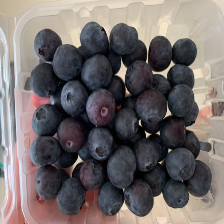

In [55]:
img = open_image(path/'test.png')
img = img.resize(224)
img

In [ ]:
img2 = open_image(path/'test2.png')
img2 = img2.resize(224)
img2

In [56]:
learn = load_learner(path)

In [58]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class 

Category tensor(1)

In [60]:
data.classes

['black', 'blue', 'grape']

**Thus this predicted the image correctly as blue-berries... pretty cool!**